# $$NLP\ Project$$
# Project Description: 
We're trying to figure out if a comment is positive or negative, in other words we want to do what we call sentiment analysis. 
We have three separate datasets, the first refers to Amazon, the second refers to imdb and the last refers to yelp.   
The objective of the study is to understand and explore the dataset, then do some transformations 'if it's necessary' and finally apply maching learning algorithms to classify new comming comment to positive or a negative one.   
We can also try, by studying comments, to predict if a comming comment was for a movie, a product or a restaurant.

# Libraries Import

In [65]:
# data ### libraries
import pandas as pd
import numpy as np
# regular expression library
import re
# Natural language Toolkit library
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#Sklearn library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# logging time
import tqdm
# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data import

In [2]:
path = 'Desktop/bureau/universite/Master DS/Projets/data viz/NLP/data'

In [3]:
#Avis sur produits vendu sur Amazon
amazon_file = pd.read_csv(path+'/amazon_cells_labelled.txt', sep='\t', header = None)
amazon_file['website'] = 'Amazon'
#Avis (imdb) sur films regardés par plusieurs personnes
imdb_file = pd.read_csv(path+'/imdb_labelled.txt', sep='\t', header = None)
imdb_file['website'] = 'imdb'
#Avis sur des restaurants (yelp)
yelp_file = pd.read_csv(path+'/yelp_labelled.txt', sep='\t', header = None)
yelp_file['website'] = 'yelp'
amazon_file.columns = imdb_file.columns = yelp_file.columns = ['sentence', 'label', 'website']

In [4]:
frames = [amazon_file,
          imdb_file,
          yelp_file]
dataset = pd.concat(frames, ignore_index=True)
dataset = dataset.sample(n=dataset.shape[0], replace=False)
dataset.reset_index(drop=True, inplace=True)

In [43]:
dataset.head()

,sentence,label,website,length
0,much better than the hard plastic cases.,1,Amazon,40
1,its extremely slow and takes forever to do any...,0,Amazon,60
2,"As many people complained, I found this headse...",0,Amazon,75
3,"Simple, lightweight and great fit.",1,Amazon,34
4,Today is the second time I've been to their lu...,1,yelp,80


# Exploratory Data Analysis:
## Description: 
As the name shows, this section will be an exploration of data using statistics and data visualization.    
The dataset is a gathering of three datas, so we can easily do our study.
Our dataset has three columns : 
- 'sentence': The comment
- 'label': 0 for negative comments and 1 for positive ones
- 'website': the source of comments ' Amazon, imdb or yelp'

## Data Exploration

For now , we 're gonna start by knowing our data shape and its distribution what will lead us to see if there are any outliers .

In [5]:
print(amazon_file.shape,
      imdb_file.shape,
      yelp_file.shape)

(1000, 3) (748, 3) (1000, 3)


- First, let's see how much negative and positive opinions we have per website

In [6]:
dataset.groupby(['label','website']).count()

sentence
label website          
0     Amazon        500
      imdb          362
      yelp          500
1     Amazon        500
      imdb          386
      yelp          500

- We can see that the data contains negative and positive opinions almost equals

In [7]:
dataset['length'] = dataset['sentence'].apply(len)
dataset['length'].describe()

count    2748.000000
mean       71.528384
std       201.987266
min         7.000000
25%        32.000000
50%        55.000000
75%        87.000000
max      7944.000000
Name: length, dtype: float64

C:\Users\amina\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


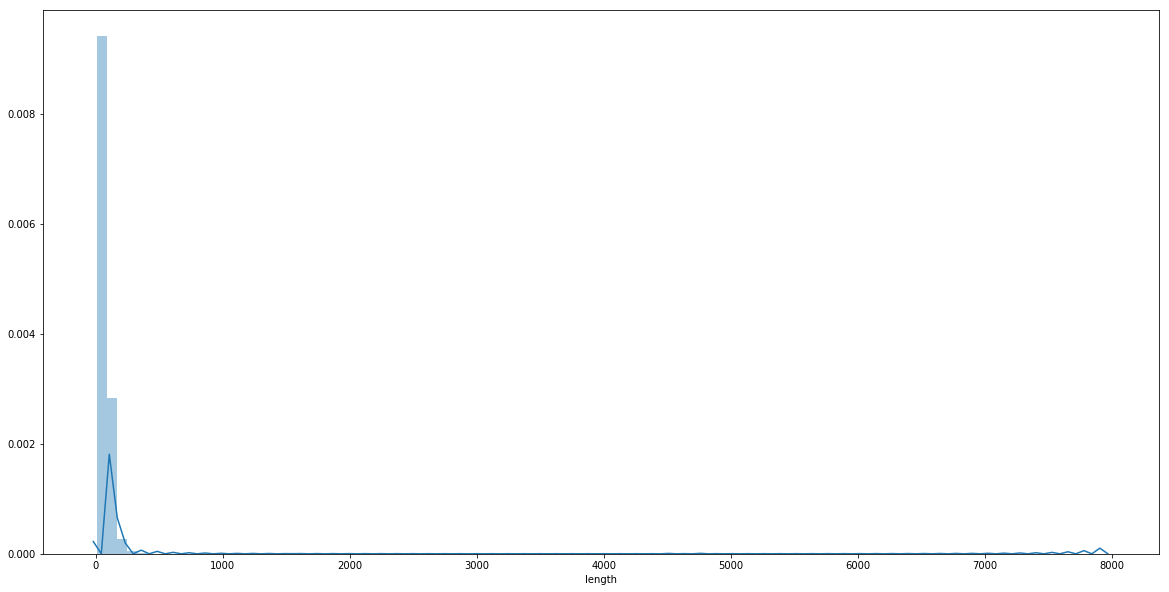

In [8]:
plt.figure(figsize=(20,10))
sns.distplot(dataset['length'], bins=100)

Based on the graph above, we can see that comments length's values are scattered, so we have outliers, which means:  
- we have a maximum length of 7944.0 and the percentile 75% is about 87.0 so 25% of lengths are between 87 and 7944.

Now we'll try to use a new method that will detect automatically the outliers. We're trying here to solve an optimization problem:   
Let 'i' be the percentage, 'Per' be percentile's function and 'cl' be comment's length, find:
$$argmax_{i}(min_{i\in [|min_i, max_i|]}(Per_{i-1}(cl)/Per_{i}(cl)))$$
- 1) Calculate all percentiles of the range (min_percentiles, max_percentiles)
- 2) Calculate the ratio percentiles[i-1]/percentiles[i]
- 3) Get the percentile where the ratio is less or equal than a threshold.

In [9]:
quantiles = pd.DataFrame()
min_, max_ = (75, 100)
quantiles['percentage'] = [(i/100) for i in range(min_, max_)]
quantiles['length_value'] = [dataset['length'].quantile(i/100) for i in range(min_, max_)]
ratios = [1]
for i in range(1, quantiles.shape[0]):
     ratios.append(quantiles.loc[i-1, 'length_value']/quantiles.loc[i, 'length_value'])
quantiles['ratios'] = ratios

In [14]:
quantiles

,percentage,length_value,ratios
0,0.75,87.00,1.000000
1,0.76,89.00,0.977528
2,0.77,90.19,0.986806
3,0.78,92.66,0.973343
4,0.79,94.00,0.985745
5,0.80,96.00,0.979167
6,0.81,99.00,0.969697
7,0.82,100.54,0.984683
8,0.83,102.00,0.985686
9,0.84,104.00,0.980769


In [46]:
threshold = 0.95
index = quantiles[quantiles.ratios<=threshold].index.values[0]
value = quantiles.length_value[index-1]
dataset = dataset[dataset.length <= value]
dataset.reset_index(drop=True, inplace=True)

In [27]:
dataset.groupby(['label','website']).count()

sentence  length
label website                  
0     Amazon        496     496
      imdb          328     328
      yelp          496     496
1     Amazon        498     498
      imdb          323     323
      yelp          498     498

- Looking up at the descriptive table , we recognize that the size of our data has dicreased from 2748 to 2639 due to the outlier filter and we have positive comments numbers almost equals to negative ones.

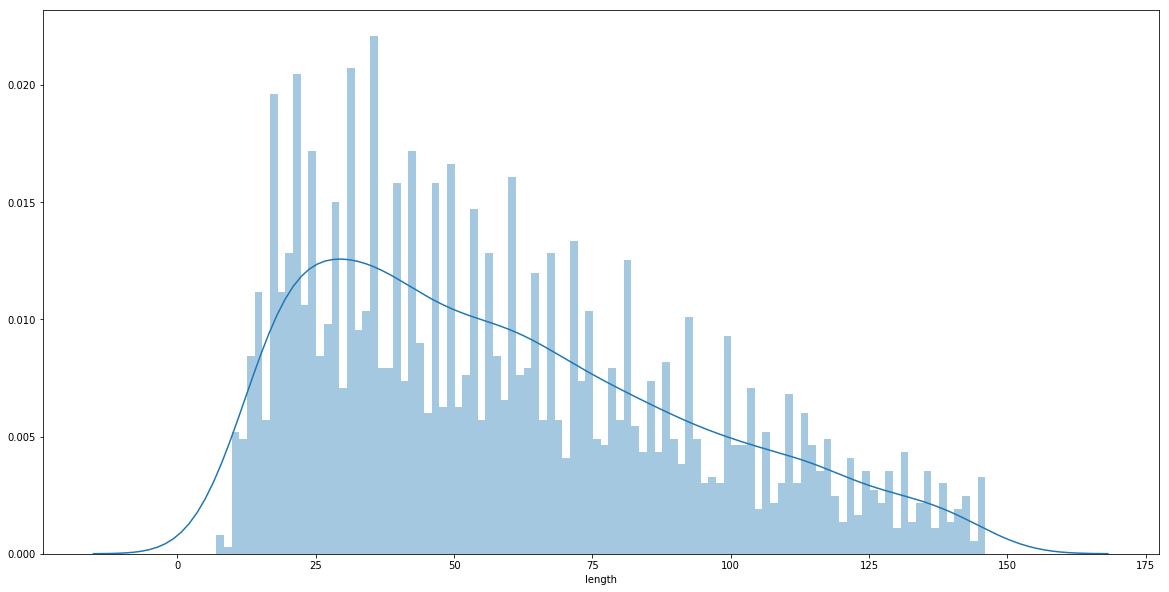

In [25]:
plt.figure(figsize=(20,10))
sns.distplot(dataset['length'], bins=100)

- Comparing this graph with previous one, we can see a huge diffrent in data's distribution . Our data is more centred.

Now let's clean comments 

In [49]:
listrev=[]

for i in tqdm.tqdm(range(dataset.shape[0])):
    review = re.sub('[^a-zA-Z]', ' ', dataset.sentence[i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    listrev.append(review)

100%|██████████| 2639/2639 [00:21<00:00, 122.06it/s]


In [51]:
dataset['sentence'] = listrev

In [53]:
# creating the Bag of words Model
cv = CountVectorizer()
X = cv.fit_transform(dataset['sentence']).toarray()
y = dataset['label'].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [64]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [67]:
y_pred = classifier.predict(X_test)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

In [68]:
cm

array([[218,  51],
       [ 70, 189]], dtype=int64)